In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import doralite
import gfdl_utils.core as gu
from CM4Xutils import *

In [147]:
def preprocess(ds):
    if "time_bounds" in ds:
        ds = ds.drop_dims("time_bounds")
    if "time_original" in ds:
        ds = ds.assign_coords({"time": xr.DataArray(ds.time_original.values, dims=("time",))}).drop_vars("time_original")
    return ds

zarr_list = [
    xr.open_zarr(f"/work/hfd/projects/CM4X/data/wmb_CM4Xp25_global_drift_{year}.zarr/")
    for year in np.arange(1750, 2100, 5)
]
ds_p25 = xr.concat([preprocess(z) for z in zarr_list], dim="time")

zarr_list = [
    xr.open_zarr(f"/work/hfd/projects/CM4X/data/wmb_CM4Xp125_global_drift_{year}.zarr/")
    for year in np.arange(1750, 2100, 5)
]
ds_p125 = xr.concat([preprocess(z) for z in zarr_list], dim="time")

In [315]:
ds = xr.concat([
    ds_p25.expand_dims({"model":["CM4Xp25"]}),
    ds_p125.expand_dims({"model":["CM4Xp125"]})
], dim="model").isel(exp=slice(None, None, -1))

In [316]:
mass_in_layer = ds.layer_mass.groupby("time.year").mean("time").compute()

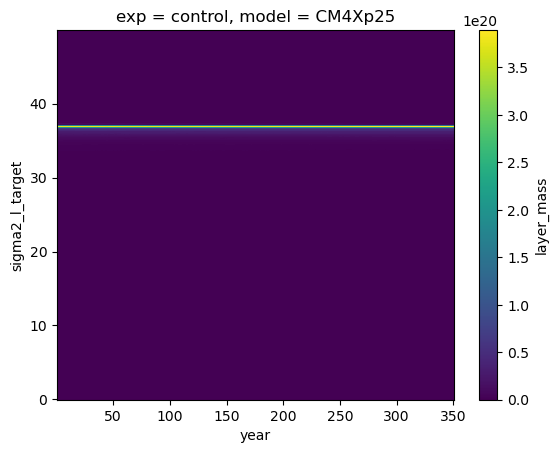

In [217]:
mass_in_layer.sel(model="CM4Xp25", exp="control").plot(x="year", )

In [189]:
mass_cumulative = mass_in_layer.sel(exp="control").sel(year=slice(250, None)).mean("year").cumsum("sigma2_l_target").compute()
mass_cdf = mass_cumulative/mass_cumulative.max("sigma2_l_target").compute()

In [201]:
upper_interface = np.abs(mass_cdf - 1./4).idxmin("sigma2_l_target").compute()
middl_interface = np.abs(mass_cdf - 2./4).idxmin("sigma2_l_target").compute()
lower_interface = np.abs(mass_cdf - 3./4).idxmin("sigma2_l_target").compute()

(0.0, 4.2997716629527115e+20)

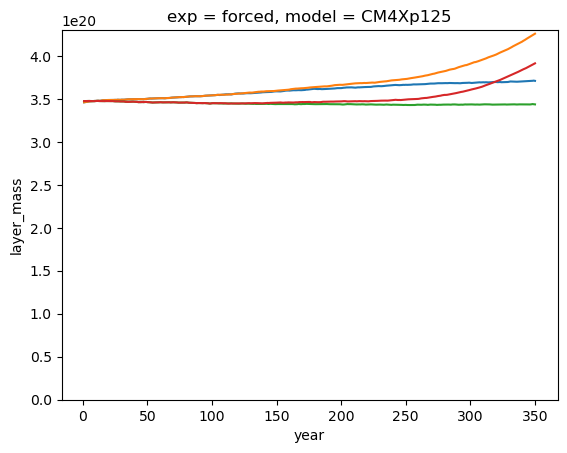

In [214]:
for model in ["CM4Xp25", "CM4Xp125"]:
    sli = slice(0, upper_interface.sel(model=model))
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="control").sum("sigma2_l_target").plot()
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="forced").sum("sigma2_l_target").plot()

plt.ylim(0, None)

(0.0, 5.02057934582483e+20)

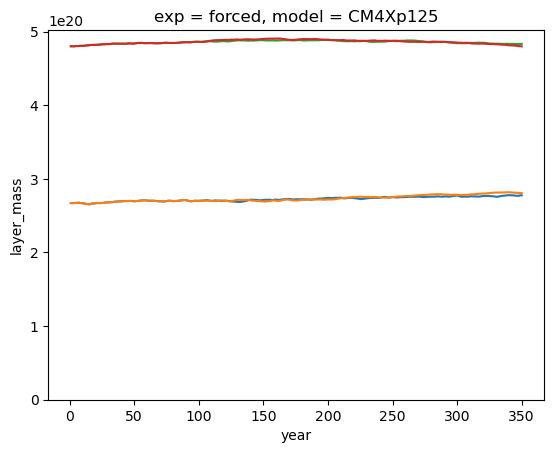

In [213]:
for model in ["CM4Xp25", "CM4Xp125"]:
    sli = slice(upper_interface.sel(model=model), middl_interface.sel(model=model))
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="control").sum("sigma2_l_target").plot()
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="forced").sum("sigma2_l_target").plot()

plt.ylim(0, None)

(0.0, 8.863639515846105e+20)

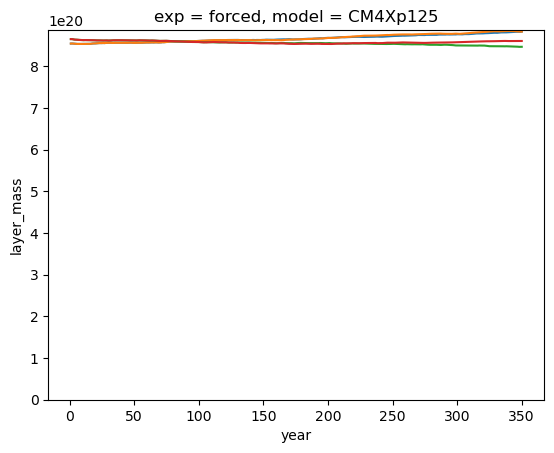

In [211]:
for model in ["CM4Xp25", "CM4Xp125"]:
    sli = slice(upper_interface.sel(model=model), lower_interface.sel(model=model))
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="control").sum("sigma2_l_target").plot()
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="forced").sum("sigma2_l_target").plot()

plt.ylim(0, None)

(0.0, 6.251291669763264e+20)

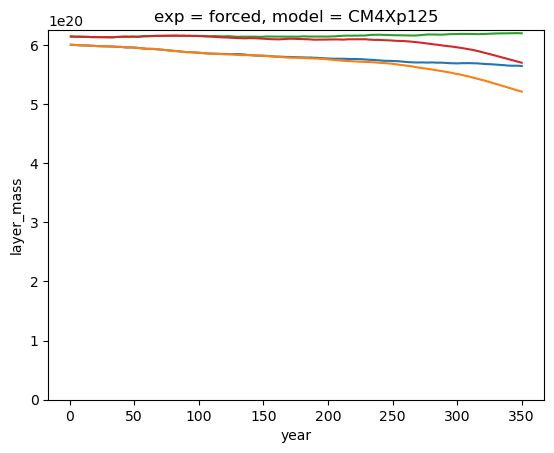

In [212]:
for model in ["CM4Xp25", "CM4Xp125"]:
    sli = slice(lower_interface.sel(model=model), None)
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="control").sum("sigma2_l_target").plot()
    mass_in_layer.sel(sigma2_l_target=sli, model=model, exp="forced").sum("sigma2_l_target").plot()

plt.ylim(0, None)

In [317]:
def rev_cumsum(da):
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1)).cumsum("sigma2_l_target")
    da = da.assign_coords({"sigma2_l_target": xr.DataArray(da.sigma2_l_target[::-1], dims=("sigma2_l_target",))})
    da = da.isel(sigma2_l_target=slice(None, None, -1))
    return da

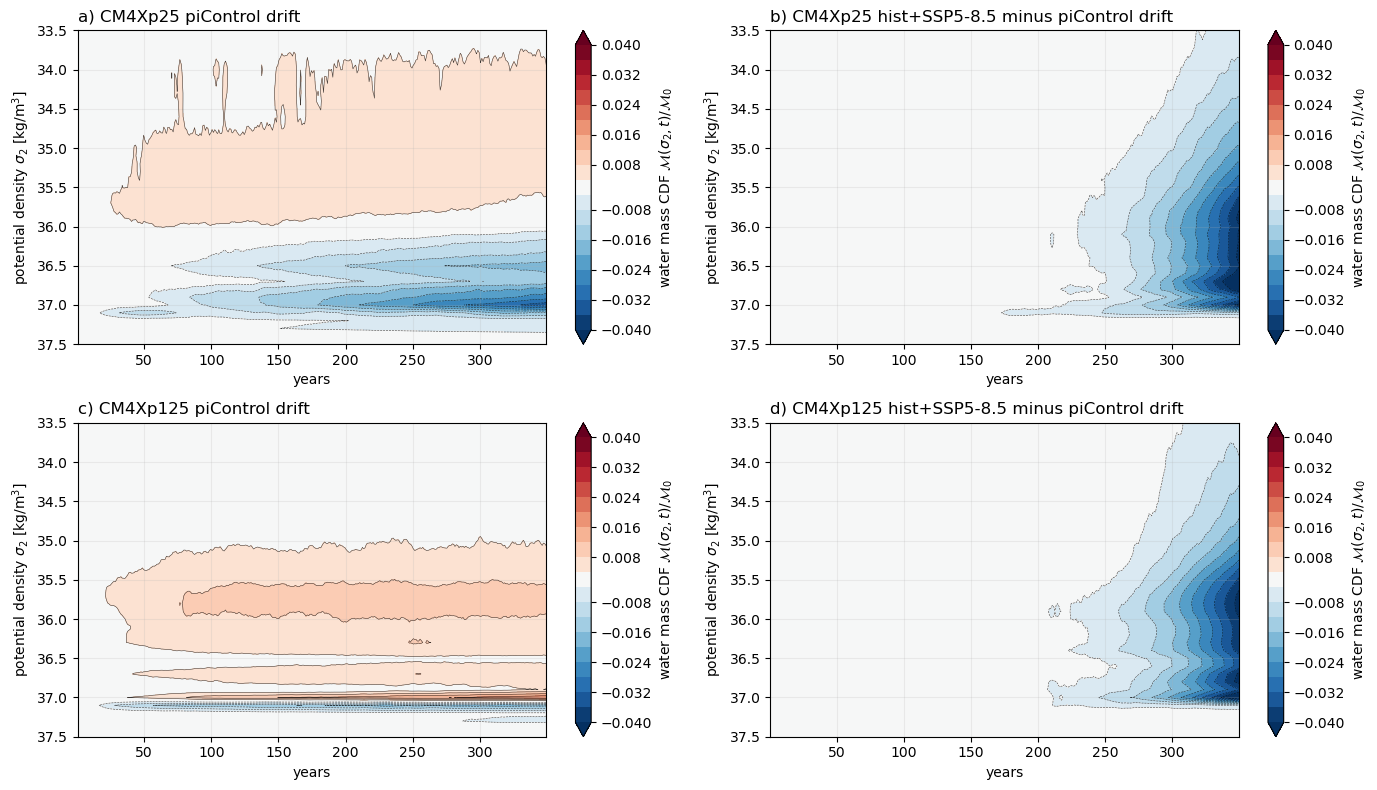

In [407]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

long_labels = {
    "control": "piControl drift",
    "forced": "hist+SSP5-8.5 minus piControl drift"
}
letter_labels = [["a)", "b)"], ["c)", "d)"]]

fig, axes = plt.subplots(2,2, figsize=(14,8))
for i, model in enumerate(ds.model):
    for j, exp in enumerate(ds.exp):
        plt.sca(axes[i,j])
        if exp=="control":
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp)) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp=exp).sel(year=1))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(250, None)).mean("year").sum()
            ).transpose()
        else:
            CDF_drift = (
                (
                    rev_cumsum(mass_in_layer.sel(model=model, exp="forced" )) -
                    rev_cumsum(mass_in_layer.sel(model=model, exp="control"))
                ) /
                mass_in_layer.sel(model=model, exp="control").sel(year=slice(250, None)).mean("year").sum()
            ).transpose()

        vmax = 4e-2
        dlev = 0.4e-2
        levels = np.concatenate((np.arange(-vmax, 0, dlev), np.arange(dlev, vmax+dlev, dlev)))
        label_levels = np.concatenate((np.arange(-vmax, 0, 2*dlev), np.arange(2*dlev, vmax+dlev, 2*dlev)))
        plt.contourf(
            np.arange(0.5, 350, 1),
            ds.sigma2_l_target.values,
            CDF_drift,
            cmap="RdBu_r",
            levels=levels,
            vmin=-vmax, vmax=vmax,
            extend="both",
            linestyles="-"
        )
        plt.colorbar(ticks=label_levels, label=r"water mass CDF $\mathcal{M}(\sigma_{2}, t) / \mathcal{M}_{0}$")
        plt.contour(
            np.arange(0.5, 350, 1),
            ds.sigma2_l_target.values,
            CDF_drift,
            colors="k",
            levels=levels,
            linewidths=0.4,
            alpha=0.75
        )
        plt.ylim(37.5, 33.5)
        plt.title(f"{letter_labels[i][j]} {str(model.values)} {long_labels[str(exp.values)]}", loc="left")

        plt.grid(True, alpha=0.2)
        plt.xlabel("years")
        plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]")
        
plt.tight_layout()
plt.savefig("figures/CM4X")

'control'

In [364]:
np.concatenate((np.arange(-vmax, 0, 2*dlev), np.arange(2*dlev, vmax+dlev, 2*dlev)))

array([-0.04 , -0.032, -0.024, -0.016, -0.008,  0.008,  0.016,  0.024,
        0.032,  0.04 ])

In [358]:
np.concatenate((np.arange(-vmax, 0, dlev), np.arange(dlev, vmax+dlev, dlev)))

array([-0.04 , -0.036, -0.032, -0.028, -0.024, -0.02 , -0.016, -0.012,
       -0.008, -0.004,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,
        0.028,  0.032,  0.036,  0.04 ])

In [356]:
levels

array([-0.04 , -0.036, -0.032, -0.028, -0.024, -0.02 , -0.016, -0.012,
       -0.008, -0.004,  0.04 ])

In [ ]:
import matplotlib.pyplot as plt
(ds.layer_mass.sel(exp="forced") - ds.layer_mass.sel(exp="control").groupby("time.year").mean("time").isel(year=0)).plot(x="time")
plt.ylim(38, 30)

In [3]:
#grid_p25 = load_wmt_diags_CM4X("CM4Xp25", test=True, dmget=True)
#grid_p125 = load_wmt_diags_CM4X("CM4Xp125", test=True, dmget=True)

interval = "1750"
grid_p25 = load_wmt_grid("CM4Xp25", interval=interval, dmget=True)
#grid_p125 = load_wmt_grid("CM4Xp125", interval=interval, dmget=True)

Loading CM4Xp25-piControl-spinup for interval `1750`.
Issuing dmget command to migrate data to disk. Migration complete.
['/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.000101-000512.boundary_forcing_heat_tendency.nc', '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.000101-000512.boundary_forcing_salt_tendency.nc', '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.000101-000512.frazil_heat_tendency.nc', '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.000101-000512.internal_heat_heat_tendency.nc', '/archive/Raphael.Dussin/FM

In [4]:
import xbudget
budgets_dict_p25 = xbudget.load_preset_budget(model="MOM6_drift")
xbudget.collect_budgets(grid_p25, budgets_dict_p25)

In [5]:
import xwmb
wmb = xwmb.WaterMassBudget(
    grid_p25,
    budgets_dict_p25
)

In [6]:
wmb.mass_budget("sigma2", greater_than=True, default_bins=True, integrate=True, along_section=False);

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._d

In [12]:
budgets_dict_p25

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'var': None,
   'sum': {'var': None, 'Eulerian_tendency': {'var': None}}},
  'rhs': {'var': None,
   'sum': {'var': None,
    'advection': {'var': None},
    'surface_exchange_flux': {'var': None}}}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'var': None,
   'sum': {'var': None,
    'Eulerian_tendency': {'var': None},
    'surface_ocean_flux_advective_negative_lhs': {'var': None}}},
  'rhs': {'var': None,
   'sum': {'var': None,
    'diffusion': {'var': None},
    'surface_exchange_flux': {'var': None},
    'surface_ocean_flux_advective_negative_rhs': {'var': None},
    'bottom_flux': {'var': None},
    'frazil_ice': {'var': None}}}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'var': None,
   'sum': {'var': None,
    'Eulerian_tendency': {'var': None},
    'advection': {'var': None, 'sum': {'var': None}},
    'surface_ocean_flux_advective_negative_lhs': {'var': None}}},
  'r

In [7]:
import xbudget
budgets_dict_p25 = xbudget.load_preset_budget(model="MOM6_drift")
xbudget.collect_budgets(grid_p25, budgets_dict_p25)

budgets_dict_p125 = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid_p125, budgets_dict_p125)

KeyError: "No variable named 'dhdt'. Variables on the dataset include ['S_advection_xy', 'average_DT', 'average_T1', 'average_T2', 'time_bnds', ..., 'wet_v', 'wet_u', 'wet', 'sigma2', 'sigma2_bounds']"

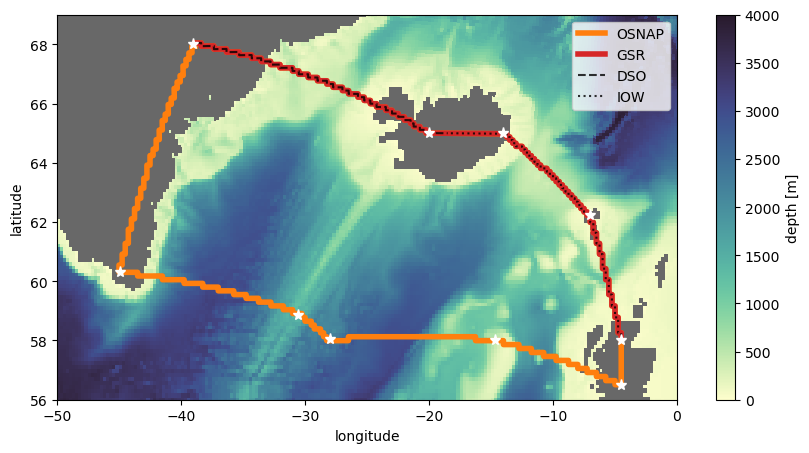

In [16]:
import matplotlib.pyplot as plt
import cmocean
import regionate
import xwmb

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "IrmingerIceland"
lons = np.array([-39.,  -20.,  -14,  -7.0, -4.5,  -4.5, -14.7, -28.00, -30.54, -44.90])
lats = np.array([ 68,     65,   65, 62.25,   58,  56.5,  58.0,  58.05,  58.86,  60.30])
region = regionate.GriddedRegion(name, lons, lats, grid_p125)

plt.figure(figsize=(10, 5))
p_ranges = {
    "DSO": np.arange(0, 110),
    "IOW": np.arange(110, 224),
    "GSR": np.arange(0, 224),
    "OSNAP-EAST": np.arange(224, region.lons.size),
}

pc = plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'],
    cmap=cmocean.cm.deep,
    vmin=0, vmax=4000
)
plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'].where(grid_p125._ds['deptho']==0)+1.,
    cmap="Greys", vmin=0, vmax=1.5
)
plt.colorbar(pc, label="depth [m]")

plt.plot(region.lons, region.lats, lw=4, color="C1", label="OSNAP")
plt.plot(region.lons[p_ranges["GSR"]], region.lats[p_ranges["GSR"]], lw=4, color="C3", label="GSR")
plt.plot(region.lons[p_ranges["DSO"]], region.lats[p_ranges["DSO"]], "--", color="k", lw=1.5, alpha=0.8, label="DSO")
plt.plot(region.lons[p_ranges["IOW"]], region.lats[p_ranges["IOW"]], ":", color="k", lw=1.5, alpha=0.8, label="IOW")
plt.plot(lons, lats, "w*", markersize=8)

plt.legend()
plt.xlabel("longitude");
plt.ylabel("latitude");

plt.ylim(56, 69)
plt.xlim(-50, 0);
plt.savefig("figures/OSNAP-East_map.png", dpi=250, bbox_inches="tight")

In [7]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [8]:
toSv = 1/1035*1e-6
wmt_mean = wmt.isel(exp=0).mean("time")*toSv
wmt_mean.load();

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_along = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb_along.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=True)

In [10]:
transport_mean = wmb_along.grid._ds['convergent_mass_transport_along'].isel(exp=0).mean("time")*toSv
transport_mean.load();

In [11]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

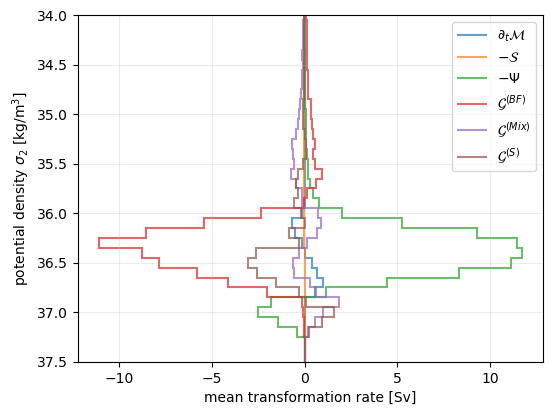

In [17]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport', label=r"$-\Psi$",                   **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(S)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.0);
plt.savefig("figures/OSNAP-East_water_mass_budget.png", dpi=250, bbox_inches="tight")

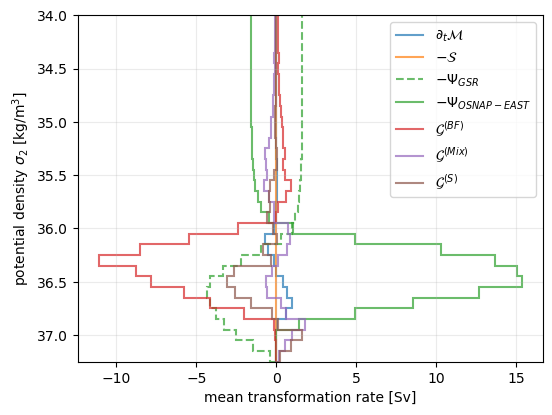

In [13]:
plt.figure(figsize=(6,4.5))

wmt_mean["convergent_mass_transport_GSR"] = transport_mean.isel(sect=p_ranges["GSR"]).sum("sect")
wmt_mean["convergent_mass_transport_OSNAP-EAST"] = transport_mean.isel(sect=p_ranges["OSNAP-EAST"]).sum("sect")

stairs( wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}$",**kwargs)
stairs(-wmt_mean, 'mass_source',               label=r"$-\mathcal{S}$",            **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_GSR', label=r"$-\Psi_{GSR}$", **kwargs, color="C2", linestyle="--")
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST}$", **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(S)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);

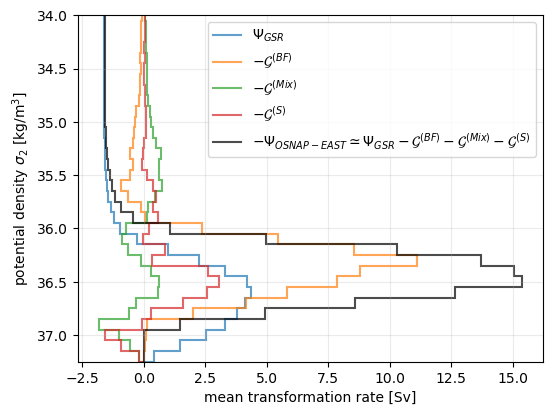

In [18]:
plt.figure(figsize=(6,4.5))

stairs(wmt_mean, 'convergent_mass_transport_GSR', label=r"$\Psi_{GSR}$", **kwargs)
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST} \simeq \Psi_{GSR} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);

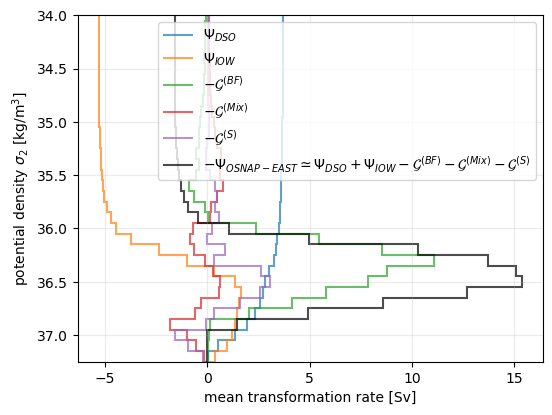

In [19]:
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

wmt_mean["convergent_mass_transport_DSO"] = transport_mean.isel(sect=p_ranges["DSO"]).sum("sect")
wmt_mean["convergent_mass_transport_IOW"] = transport_mean.isel(sect=p_ranges["IOW"]).sum("sect")

stairs(wmt_mean, 'convergent_mass_transport_DSO', label=r"$\Psi_{DSO}$", **kwargs)
stairs(wmt_mean, 'convergent_mass_transport_IOW', label=r"$\Psi_{IOW}$", **kwargs)
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-EAST', label=r"$-\Psi_{OSNAP-EAST} \simeq \Psi_{DSO} + \Psi_{IOW} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);
plt.savefig("figures/OSNAP-East_outflow_decomposition.png", dpi=250, bbox_inches="tight")

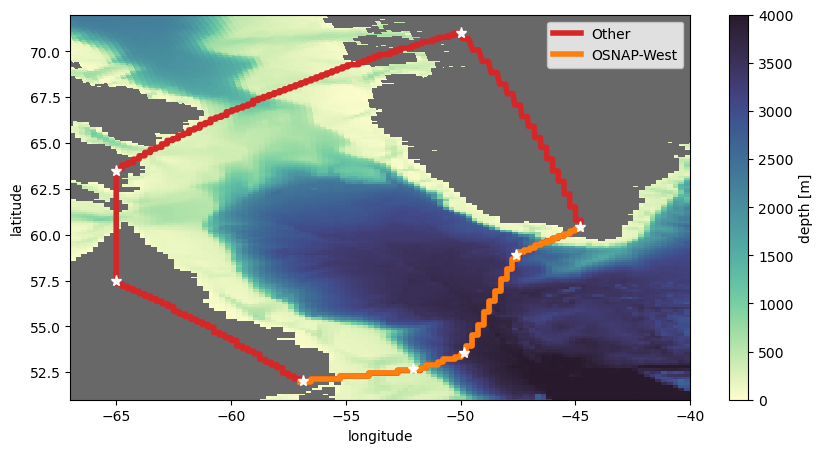

In [46]:
import matplotlib.pyplot as plt
import cmocean
import regionate
import xwmb

# Note: the properties of this region are quite different from the rest of the Baltic!
name = "Labrador"
lons = np.array([-56.8775, -52.0956, -49.8604, -47.6107, -44.8000, -50, -65, -65])
lats = np.array([52.0166, 52.6648, 53.5577, 58.8944, 60.4000, 71, 63.5, 57.5])

region = regionate.GriddedRegion(name, lons, lats, grid_p125)

plt.figure(figsize=(10, 5))
p_ranges = {
    "OSNAP-West": np.arange(0, 110),
    "OTHER": np.arange(110, region.lons.size),
}

pc = plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'],
    cmap=cmocean.cm.deep,
    vmin=0, vmax=4000
)
plt.pcolor(
    grid_p125._ds['geolon_c'],
    grid_p125._ds['geolat_c'],
    grid_p125._ds['deptho'].where(grid_p125._ds['deptho']==0)+1.,
    cmap="Greys", vmin=0, vmax=1.5
)
plt.colorbar(pc, label="depth [m]")

plt.plot(region.lons, region.lats, lw=4, color="C3", label="Other")
plt.plot(region.lons[p_ranges["OSNAP-West"]], region.lats[p_ranges["OSNAP-West"]], lw=4, color="C1", label="OSNAP-West")
plt.plot(lons, lats, "w*", markersize=8)

plt.legend()
plt.xlabel("longitude");
plt.ylabel("latitude");

plt.ylim(51, 72)
plt.xlim(-67,-40);
plt.savefig("figures/OSNAP-West_map.png", dpi=250, bbox_inches="tight")

In [39]:
import warnings

lam = "sigma2"
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=False)
    wmt = wmb.wmt

In [41]:
toSv = 1/1035*1e-6
wmt_mean = wmt.isel(exp=0).mean("time")*toSv
wmt_mean.load();

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb_along = xwmb.WaterMassBudget(
        grid_p125,
        budgets_dict_p125,
        region
    )
    wmb_along.mass_budget(lam, greater_than=True, default_bins=True, integrate=True, along_section=True)

In [43]:
transport_mean = wmb_along.grid._ds['convergent_mass_transport_along'].isel(exp=0).mean("time")*toSv
transport_mean.load();

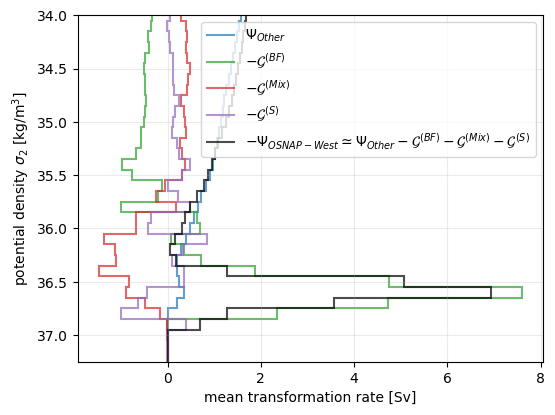

In [47]:
plt.figure(figsize=(6,4.5))

wmt_mean["convergent_mass_transport_OSNAP-West"] = transport_mean.isel(sect=p_ranges["OSNAP-West"]).sum("sect")
wmt_mean["convergent_mass_transport_OTHER"] = transport_mean.isel(sect=p_ranges["OTHER"]).sum("sect")

stairs(wmt_mean, 'convergent_mass_transport_OTHER', label=r"$\Psi_{Other}$", **kwargs)
plt.plot([], [])
stairs(-wmt_mean, 'boundary_fluxes',           label=r"$-\mathcal{G}^{(BF)}$",      **kwargs)
stairs(-wmt_mean, 'diffusion',                 label=r"$-\mathcal{G}^{(Mix)}$",     **kwargs)
stairs(-wmt_mean, 'spurious_numerical_mixing', label=r"$-\mathcal{G}^{(S)}$", **kwargs)
stairs(-wmt_mean, 'convergent_mass_transport_OSNAP-West', label=r"$-\Psi_{OSNAP-West} \simeq \Psi_{Other} -\mathcal{G}^{(BF)} -\mathcal{G}^{(Mix)} -\mathcal{G}^{(S)}$", color="k", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.25, 34.0);
plt.savefig("figures/OSNAP-West_outflow_decomposition.png", dpi=250, bbox_inches="tight")